In [5]:
library(ggplot2)
library(dplyr)
library(tidyverse)
library(reshape2)
library(wesanderson)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.4     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [6]:
#Function for grouping variables on one line

# Generic form
'%=%' = function(l, r, ...) UseMethod('%=%')

# Binary Operator
'%=%.lbunch' = function(l, r, ...) {
  Envir = as.environment(-1)

  if (length(r) > length(l))
    warning("RHS has more args than LHS. Only first", length(l), "used.")

  if (length(l) > length(r))  {
    warning("LHS has more args than RHS. RHS will be repeated.")
    r <- extendToMatch(r, l)
  }

  for (II in 1:length(l)) {
    do.call('<-', list(l[[II]], r[[II]]), envir=Envir)
  }
}

# Used if LHS is larger than RHS
extendToMatch <- function(source, destin) {
  s <- length(source)
  d <- length(destin)

  # Assume that destin is a length when it is a single number and source is not
  if(d==1 && s>1 && !is.null(as.numeric(destin)))
    d <- destin

  dif <- d - s
  if (dif > 0) {
    source <- rep(source, ceiling(d/s))[1:d]
  }
  return (source)
}
# Grouping the left hand side
g = function(...) {
  List = as.list(substitute(list(...)))[-1L]
  class(List) = 'lbunch'
  return(List)
}

In [7]:
setwd('/home/gdreynolds/GCA_analysis/bulk_data')
metadata<-read.csv('clinical_metadata.csv', row.names = 1)


***Autogenes output***


In [42]:
#Choose metadata
g(Status, Status1, Status2) %=% c('diagnosis', 'NOT', 'GCA')

#g(Status, Status1, Status2) %=% c('visual_loss', 'No_visual_loss', 'Visual_loss')

In [74]:
setwd('/home/gdreynolds/GCA_analysis/bulk_data')
autogenes_NuSVR<-read.csv('autogenes_tissue_NuSVR_output_240922.csv')
autogenes_nnls<-read.csv('autogenes_tissue_nnls_output_240922.csv')

In [75]:
autogenes_NuSVR[Status]<-metadata[Status]
autogenes_nnls[Status]<-metadata[Status]

In [76]:
autogenes_NuSVR$X<-NULL
autogenes_NuSVR<-melt(autogenes_NuSVR, id = Status)
colnames(autogenes_NuSVR)<-c(paste0(Status), 'celltype', 'props')
autogenes_NuSVR$props <- as.numeric(autogenes_NuSVR$props)

In [77]:
autogenes_nnls$X<-NULL
autogenes_nnls<-melt(autogenes_nnls, id = Status)
colnames(autogenes_nnls)<-c(paste0(Status), 'celltype', 'props')
autogenes_nnls$props <- as.numeric(autogenes_nnls$props)

In [78]:
autogenes_NuSVR$diagnosis<-factor(autogenes_NuSVR$diagnosis, levels = c('NOT', 'GCA'))
autogenes_nnls$diagnosis<-factor(autogenes_nnls$diagnosis, levels = c('NOT', 'GCA'))

#autogenes_NuSVR$visual_loss<-factor(autogenes_NuSVR$visual_loss, levels = c('No_visual_loss', 'Visual_loss'))
#autogenes_nnls$visual_loss<-factor(autogenes_nnls$visual_loss, levels = c('No_visual_loss', 'Visual_loss'))

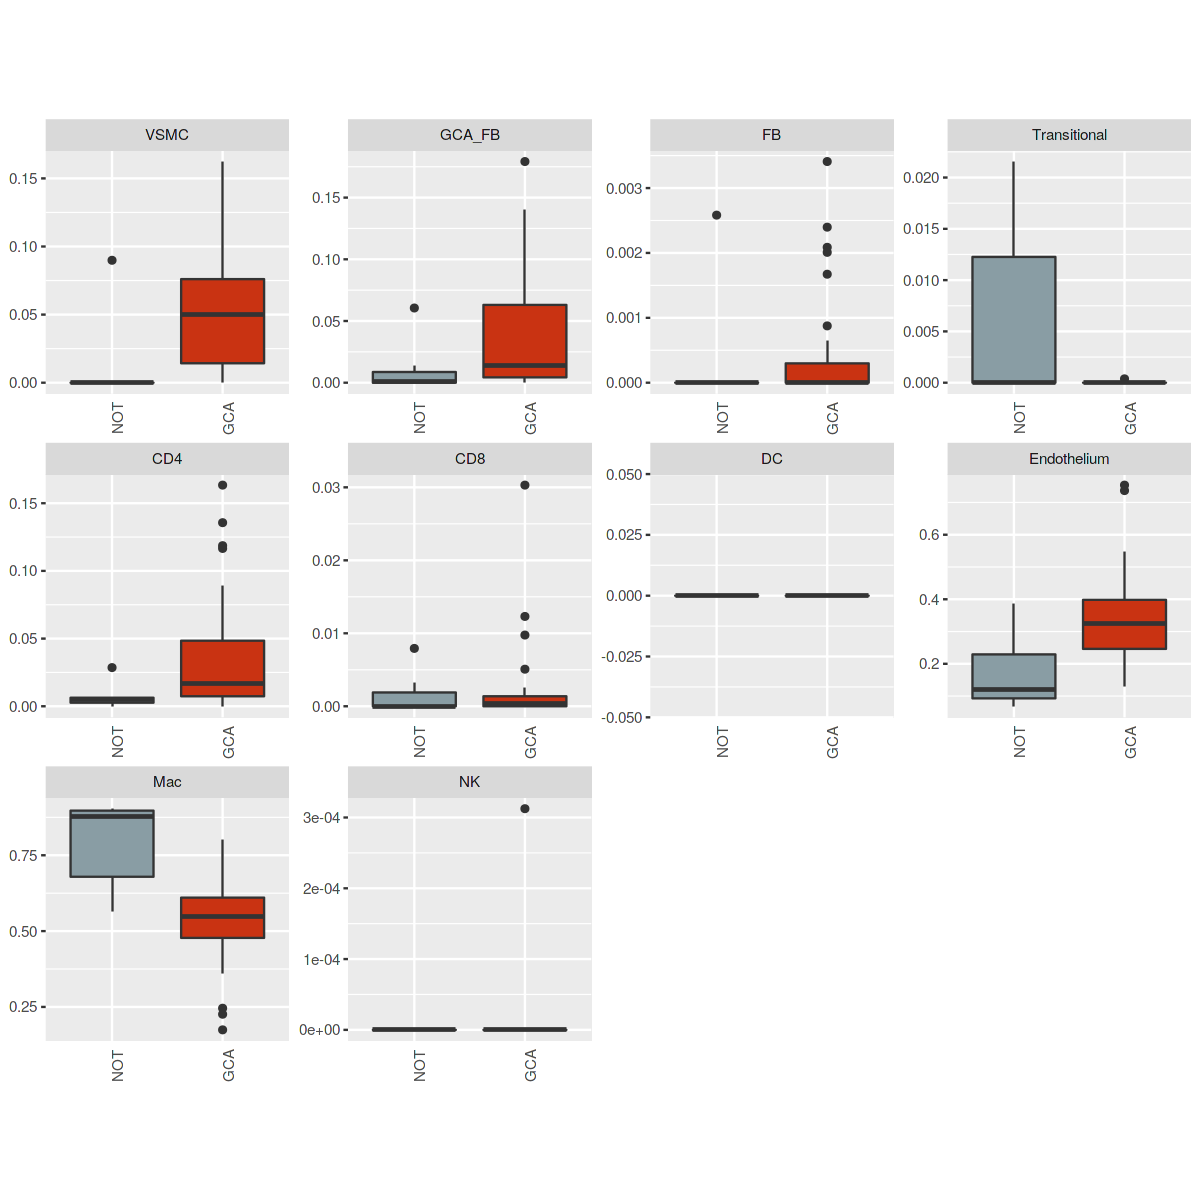

In [79]:
#labelled plot

options(repr.plot.width=10, repr.plot.height=10)

ggplot(data=autogenes_NuSVR, aes_string(x=Status, y='props', fill=Status)) +
    geom_boxplot() +
scale_fill_manual(values = wes_palette("Royal1"))+
      theme(aspect.ratio = 1/1) + 
facet_wrap(~celltype, scales = "free")+
theme(axis.text.x = element_text(angle = 90)) +
theme(axis.title.x=element_blank(),
       #axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
#           axis.text.y=element_blank(),
      axis.title.y=element_blank()) +
theme(legend.position="none") 

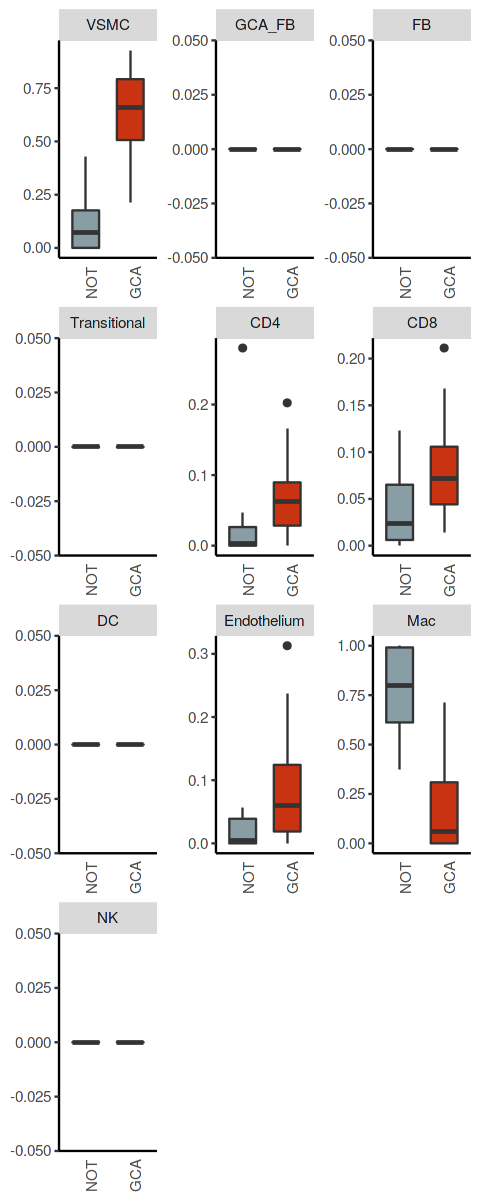

In [80]:
#unlabelled plot

options(repr.plot.width=4, repr.plot.height=10)

ggplot(data=autogenes_nnls, aes_string(x=Status, y='props', fill=Status)) +
    geom_boxplot(width = 0.6) +
scale_fill_manual(values = wes_palette("Royal1"))+
#      theme(aspect.ratio = 1/1) + 
facet_wrap(~celltype, scales = "free", ncol = 3)+
theme(axis.text.x = element_text(angle = 90)) +
theme(axis.title.x=element_blank(),
       #axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
 #          axis.text.y=element_blank(),
      axis.title.y=element_blank()) +
theme(legend.position="none") + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

In [81]:
celltypes<-unique(autogenes_nnls$celltype)

l<-list()
for(i in unique(celltypes)){
    temp<-autogenes_nnls %>% filter(celltype == i)
    temp_result<-wilcox.test(filter(temp, !!as.symbol(Status) == Status1)$props, filter(temp, !!as.symbol(Status) == Status2)$props, alternative = "two.sided") 
    l[i]<-temp_result$p.value    
}


a<-data.frame(t(data.frame(l)))
colnames(a)<-'nnls'
a$nnls<-a$nnls*7


celltypes<-unique(autogenes_NuSVR$celltype)

l<-list()
for(i in unique(celltypes)){
    temp<-autogenes_NuSVR %>% filter(celltype == i)
    temp_result<-t.test(filter(temp, !!as.symbol(Status) == Status1)$props, filter(temp, !!as.symbol(Status) == Status2)$props, alternative = "two.sided") 
    l[i]<-temp_result$p.value    
}

b<-data.frame(t(data.frame(l)))
colnames(b)<-'NuSVR'
b$NuSVR<-b$NuSVR*7

stats<-cbind(a,b)

Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbo

In [82]:
options(scipen = 999)
stats
options(scipen = 0)

,nnls,NuSVR
,<dbl>,<dbl>
VSMC,0.0007309845,0.16422703
GCA_FB,NaN,0.32586407
FB,NaN,6.14091174
Transitional,NaN,0.67132430
CD4,0.1251245129,0.01298712
CD8,0.1573602896,4.95428155
DC,NaN,NaN
Endothelium,0.3150017156,0.04899962
Mac,0.0006384638,0.02131105


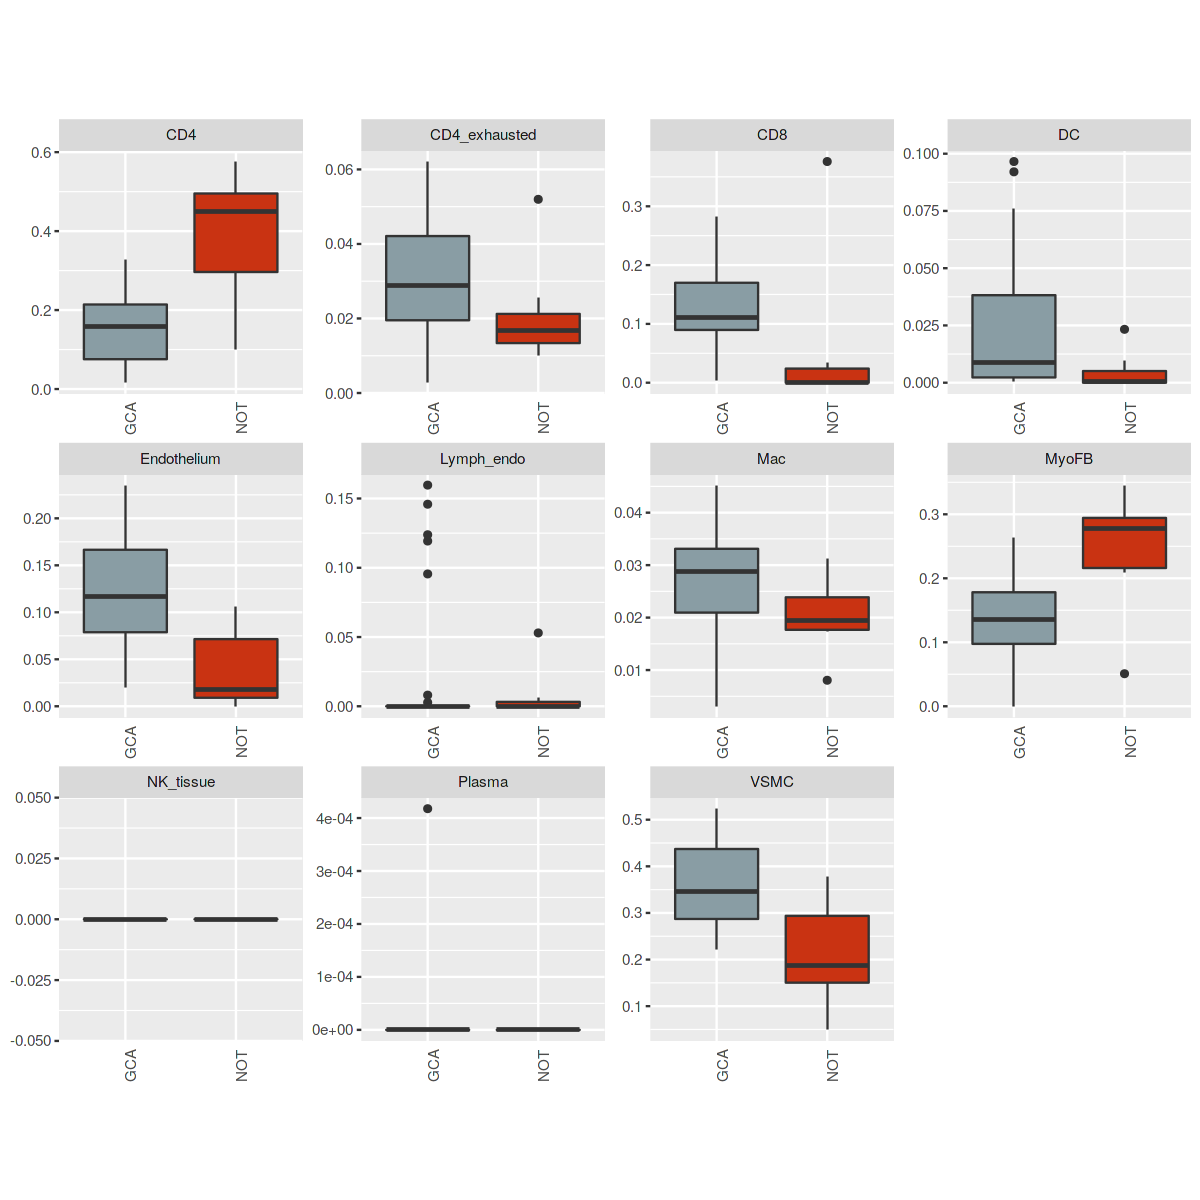

In [24]:
#labelled plot

options(repr.plot.width=10, repr.plot.height=10)

ggplot(data=autogenes_nnls, aes_string(x=Status, y='props', fill=Status)) +
    geom_boxplot() +
scale_fill_manual(values = wes_palette("Royal1"))+
      theme(aspect.ratio = 1/1) + 
facet_wrap(~celltype, scales = "free")+
theme(axis.text.x = element_text(angle = 90)) +
theme(axis.title.x=element_blank(),
       #axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
#           axis.text.y=element_blank(),
      axis.title.y=element_blank()) +
theme(legend.position="none") 

In [172]:
celltypes<-unique(autogenes_nnls$celltype)

l<-list()
for(i in unique(celltypes)){
    temp<-autogenes_nnls %>% filter(celltype == i)
    temp_result<-wilcox.test(filter(temp, !!as.symbol(Status) == Status1)$props, filter(temp, !!as.symbol(Status) == Status2)$props, alternative = "two.sided") 
    l[i]<-temp_result$p.value    
}

Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbol(Status) == Status1)$props, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(temp, !!as.symbo

In [173]:
t(data.frame(l))

CD4_1_tissue,0.1024590797
CD4_2_tissue,NaN
Treg_tissue,0.1104727852
CD8_tissue,0.0001262634
Plasma_tissue,NaN
Mac1_tissue,0.0027389978
Mac2_tissue,0.6930118864
Mac3_tissue,NaN
DC_tissue,0.0013566076
Epi_tissue,0.0010439190
Endothelium_tissue,0.0202404476



***CIBERSORT***


In [32]:
setwd('/home/gdreynolds/GCA_analysis/bulk_data')
cibersort_decon<-read.csv('CIBERSORT_tissue_output_210915.txt', sep = '\t')

In [33]:
cibersort_decon <- cibersort_decon %>% select(-(one_of('P.value', 'Correlation', 'RMSE')))

In [34]:
cibersort_decon$visual_loss<-metadata$visual_loss

In [36]:
cibersort_decon$Mixture<-NULL
cibersort_decon<-melt(cibersort_decon, id = 'visual_loss')
colnames(cibersort_decon)<-c('visual_loss', 'celltype', 'props')
cibersort_decon$props <- as.numeric(cibersort_decon$props)

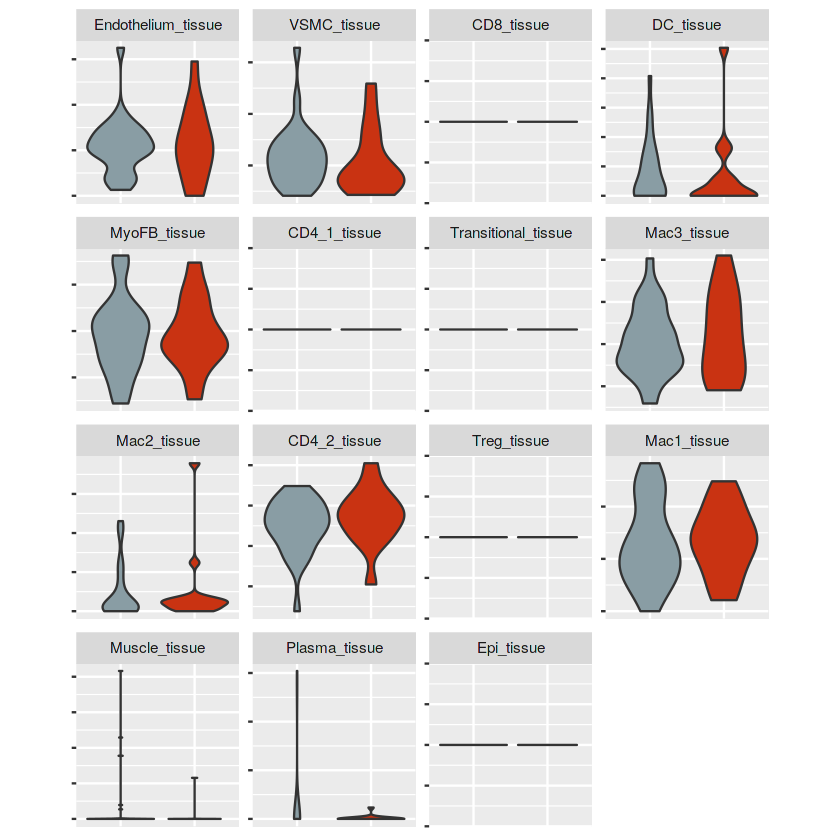

In [37]:
ggplot(data=cibersort_decon, aes(x=visual_loss, y=props, fill=visual_loss)) +
    geom_violin() +
scale_fill_manual(values = wes_palette("Royal1"))+
      theme(aspect.ratio = 1/1) + 
facet_wrap(~celltype, scales = "free")+
theme(axis.text.x = element_text(angle = 90)) +
theme(axis.title.x=element_blank(),
       axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
           axis.text.y=element_blank(),
      axis.title.y=element_blank()) +
theme(legend.position="none") 

In [40]:
celltypes<-unique(cibersort_decon$celltype)

l<-list()
for(i in unique(celltypes)){
    tryCatch(
    {temp<-wilcox.test(filter(cibersort_decon, celltype == i & visual_loss == 'Visual_loss')$props, filter(cibersort_decon, celltype == i & visual_loss == 'No_visual_loss')$props, alternative = "two.sided")}, 
    error = function(e) {
        paste0(i, "did not run")})
    l[i]<-temp$p.value    
}

names(l)<-celltypes

Warning message in wilcox.test.default(filter(cibersort_decon, celltype == i & visual_loss == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(cibersort_decon, celltype == i & visual_loss == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(cibersort_decon, celltype == i & visual_loss == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(cibersort_decon, celltype == i & visual_loss == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(cibersort_decon, celltype == i & visual_loss == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(cibersort_decon, celltype == i & visual_loss == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(filter(cibersort_decon, celltype == i & visual_loss == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(fi

In [41]:
t(data.frame(l))

Endothelium_tissue,0.9660712
VSMC_tissue,0.3763334
CD8_tissue,NaN
DC_tissue,0.3488548
MyoFB_tissue,0.9219537
CD4_1_tissue,NaN
Transitional_tissue,NaN
Mac3_tissue,0.9888335
Mac2_tissue,0.8870687
CD4_2_tissue,0.3917727
Treg_tissue,NaN


In [53]:
setwd('/home/gdreynolds/GCA_analysis/scPopcorn/output')
result = read.csv('Cochain_vs_GCA.txt', sep = '\t', row.names = 1)

In [54]:
result

,X1
,<int>
ACACCAAGTACTCAAC-GCA100_T1,1
ACACCGGGTCAATACC-GCA100_T1,1
ACACTGAAGTTTGCGT-GCA100_T1,1
ACGCCGATCGAACTGT-GCA100_T1,1
ACGGGTCAGCGTTCCG-GCA100_T1,1
ACTATCTCACACAGAG-GCA100_T1,1
ACTGAGTTCATGCATG-GCA100_T1,1
ACTTACTAGACAAGCC-GCA100_T1,0
AGCAGCCAGAAGAAGC-GCA100_T1,1
